In [1]:
import os
import struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT_PATH = '/home/mitchell/cgp/CGPExperiments/build/'
CHECKPOINT_PATH = ROOT_PATH + 'ckpt/'
LOG_FILE_PATH = CHECKPOINT_PATH + 'log.txt'

INPUT_PATH = ROOT_PATH + 'x.dat'
LABELS_PATH = ROOT_PATH + 'y.dat'
PREDICTIONS_FILENAME = 'predictions.dat'

In [2]:
log_df = pd.read_csv(LOG_FILE_PATH)
log_df.head()

,cumulativeNumberOfEpochs,bestFitness,cumulativeElapsedTimeUs
0,100,0.452700,30390783.0
1,200,0.000763,59210701.0
2,300,0.000012,88100539.0
3,400,0.000012,116038375.0
4,500,0.000012,143653460.0


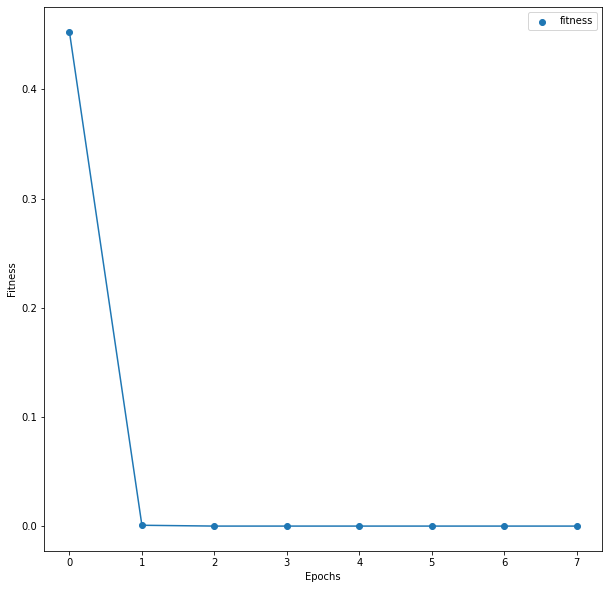

In [3]:
def plot_fitness(log_df):
    fig = plt.figure(figsize=(10,10))
    x = [i for i in range(0, log_df.shape[0], 1)]
    y = log_df['bestFitness']
    
    plt.scatter(x, y, label='fitness')
    plt.plot(x, y)
    
    plt.xlabel('Epochs')
    plt.ylabel('Fitness')
    plt.legend()
    
    plt.show()
    
plot_fitness(log_df)

0.001969997234608463
9.849986173042316e-06


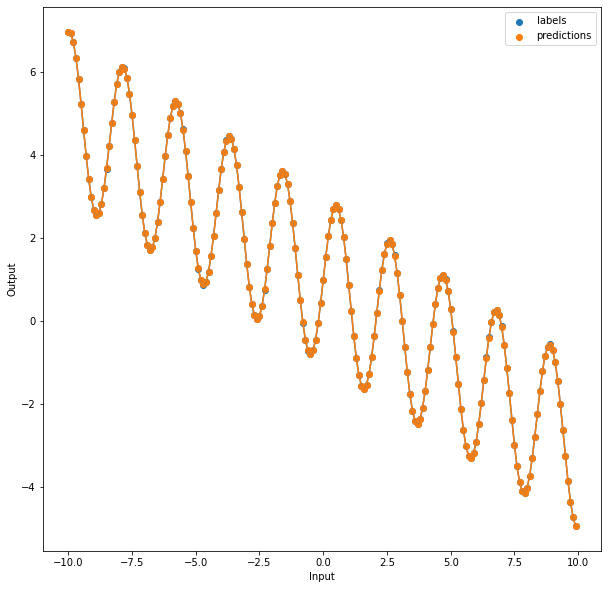

In [18]:
def read_data_file(file_name):
    file_size = os.path.getsize(file_name)
    if (file_size % 4 != 0):
        raise ValueError('File size is wrong number of bytes: {0}'.format(file_size))
        
    with open(file_name, 'rb') as f:
        data = f.read(file_size)
    
    float_size = 4
    num_floats = int(file_size / float_size)
    out_floats = []
    
    for i in range(0, num_floats, 1):
        start_idx = float_size*i
        end_idx = start_idx + float_size
        data_bytes = bytearray(data[start_idx:end_idx])
        
        out_floats.append(struct.unpack('<f', data_bytes)[0])
    
    return out_floats

def plot_predictions_and_labels(iteration_number):
    if (not isinstance(iteration_number, str)):
        iteration_number = str(iteration_number)
    x_data = read_data_file(INPUT_PATH)
    labels = read_data_file(LABELS_PATH)
    predictions = read_data_file(CHECKPOINT_PATH + iteration_number + '/' + PREDICTIONS_FILENAME)
    
    err = 0
    for i in range(0, len(x_data), 1):
        err += (predictions[i]-labels[i]) ** 2 
    
    print(err)
    print(err / len(x_data))
    fig = plt.figure(figsize=(10,10))

    plt.scatter(x_data, labels, label='labels')
    plt.plot(x_data, labels)

    plt.scatter(x_data, predictions, label='predictions')
    plt.plot(x_data, predictions)

    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend()

    plt.show()

plot_predictions_and_labels('final')